In [2]:
# Instal required libraries
%pip install numpy_financial
%pip install pyomo
%pip install -q condacolab
import condacolab
condacolab.install()
# This step might fail or crash the first time you run it. This is fine. 
# Just run the cell again and it will work.
!conda install -c conda-forge glpk


  Using cached numpy_financial-1.0.0-py3-none-any.whl.metadata (2.2 kB)
Using cached numpy_financial-1.0.0-py3-none-any.whl (14 kB)
Note: you may need to restart the kernel to use updated packages.
   ━━━━━━━━━━━━╸━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/4.1 MB 189.8 kB/s eta 0:00:15^C
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


RuntimeError: This module must ONLY run as part of a Colab notebook!

In [ ]:
# Install HyDesign
# Install hydesign if needed
import importlib
if not importlib.util.find_spec("hydesign"):
    !pip install git+https://gitlab.windenergy.dtu.dk/TOPFARM/hydesign.git    

In [3]:
import pandas as pd
import numpy as np
from datetime import datetime
from matplotlib import pyplot as plt
import os

In [ ]:
# Connect to the Google Drive so you can read the data
from google.colab import drive
drive.mount('/content/drive')

# Change directory to the folder containing the current script
os.chdir("/content/drive/MyDrive/HPP_EMS_Assignment")



### 1. Input data analysis

In the folder Data, you will find two csv files, "Wind.csv" and "Market.csv", which are the inputs of the EMS optimization model. Read the data and analyze the wind power and market price forecasting errors


In [62]:
input_wind_ts_filename = './Data/Wind.csv'
input_market_ts_filename = './Data/Market.csv'

start_date_plot = datetime(2012,1,7)
end_date_plot = datetime(2013,1,1)
date_range_15min = pd.date_range(start_date_plot,end_date_plot,freq='15min')
date_range_1h = pd.date_range(start_date_plot,end_date_plot,freq='1h')

winddata = pd.read_csv(input_wind_ts_filename)*120
marketdata = pd.read_csv(input_market_ts_filename)

winddata.index = date_range_15min[:-1]
marketdata.index = date_range_1h[:-1]

P_real = winddata['Measurement']
P_DA = winddata['DA']

SP_DA = marketdata['SM_forecast']
SP_real = marketdata['SM_cleared']

RP_DA = marketdata['reg_forecast_pre']
RP_real = marketdata['reg_cleared']




Wind Forecast nRMSE: 53.29%
Spot Price Forecast nRMSE: 61.17%


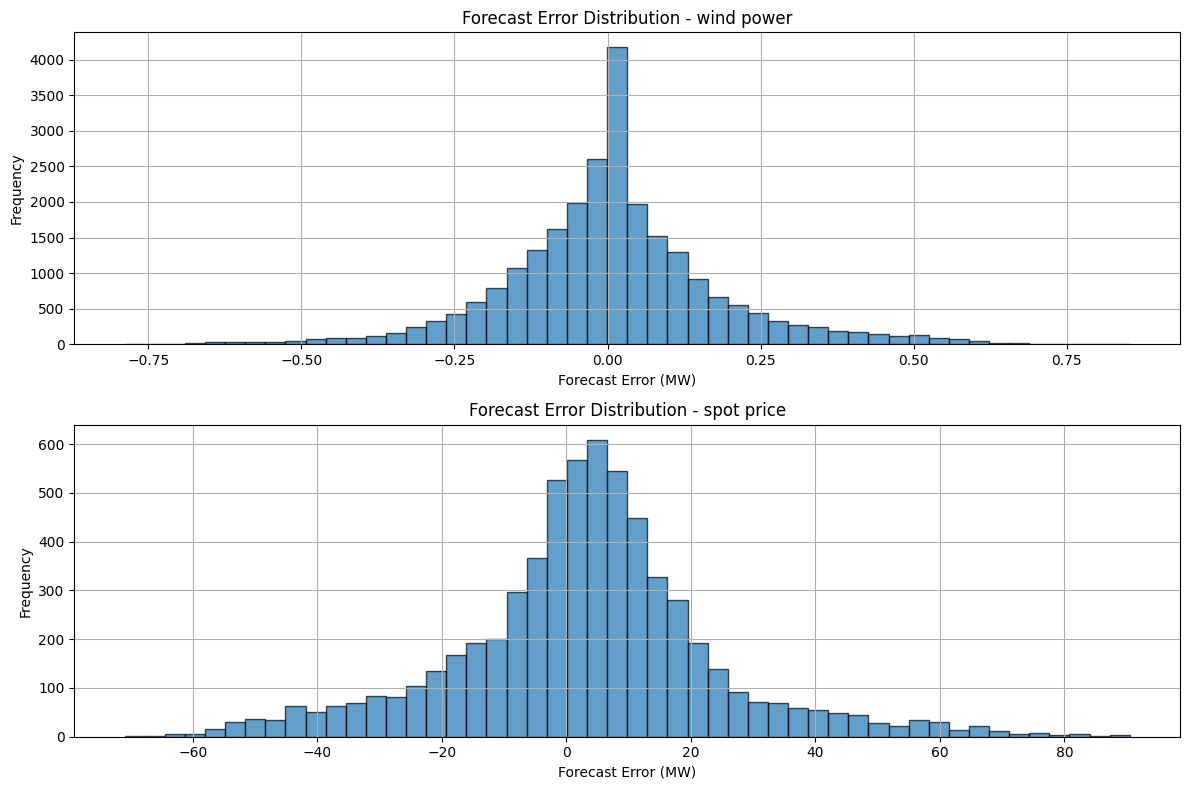

In [8]:
## Wind forecasting error distribution
## DA price forecasting error distribution
# Compute forecast errors
error_wind = P_DA - P_real
error_SP = SP_DA - SP_real

# RMSE
rmse_wind = np.sqrt(np.mean(error_wind**2))
rmse_SP = np.sqrt(np.mean(error_SP**2))

# Means
mean_wind = np.mean(P_real)
mean_SP = np.mean(SP_real)

# Normalized RMSEs
nrmse_wind = rmse_wind / mean_wind
nrmse_SP = rmse_SP / mean_SP

print(f"Wind Forecast nRMSE: {nrmse_wind:.2%}")
print(f"Spot Price Forecast nRMSE: {nrmse_SP:.2%}")

plt.figure(figsize=(12, 8))


plt.subplot(2, 1, 1)
plt.hist(error_wind, bins=50, edgecolor='black', alpha=0.7)
plt.title('Forecast Error Distribution - wind power')
plt.xlabel('Forecast Error (MW)')
plt.ylabel('Frequency')
plt.grid(True)


plt.subplot(2, 1, 2)
plt.hist(error_SP, bins=50, edgecolor='black', alpha=0.7)
plt.title('Forecast Error Distribution - spot price')
plt.xlabel('Forecast Error (MW)')
plt.ylabel('Frequency')
plt.grid(True)


plt.tight_layout()
plt.show()

### 2. Output Analysis

Running the EMS optimization requires the academic version of IBM CPLEX. 

#### 2.1 Bidding strategy analysis

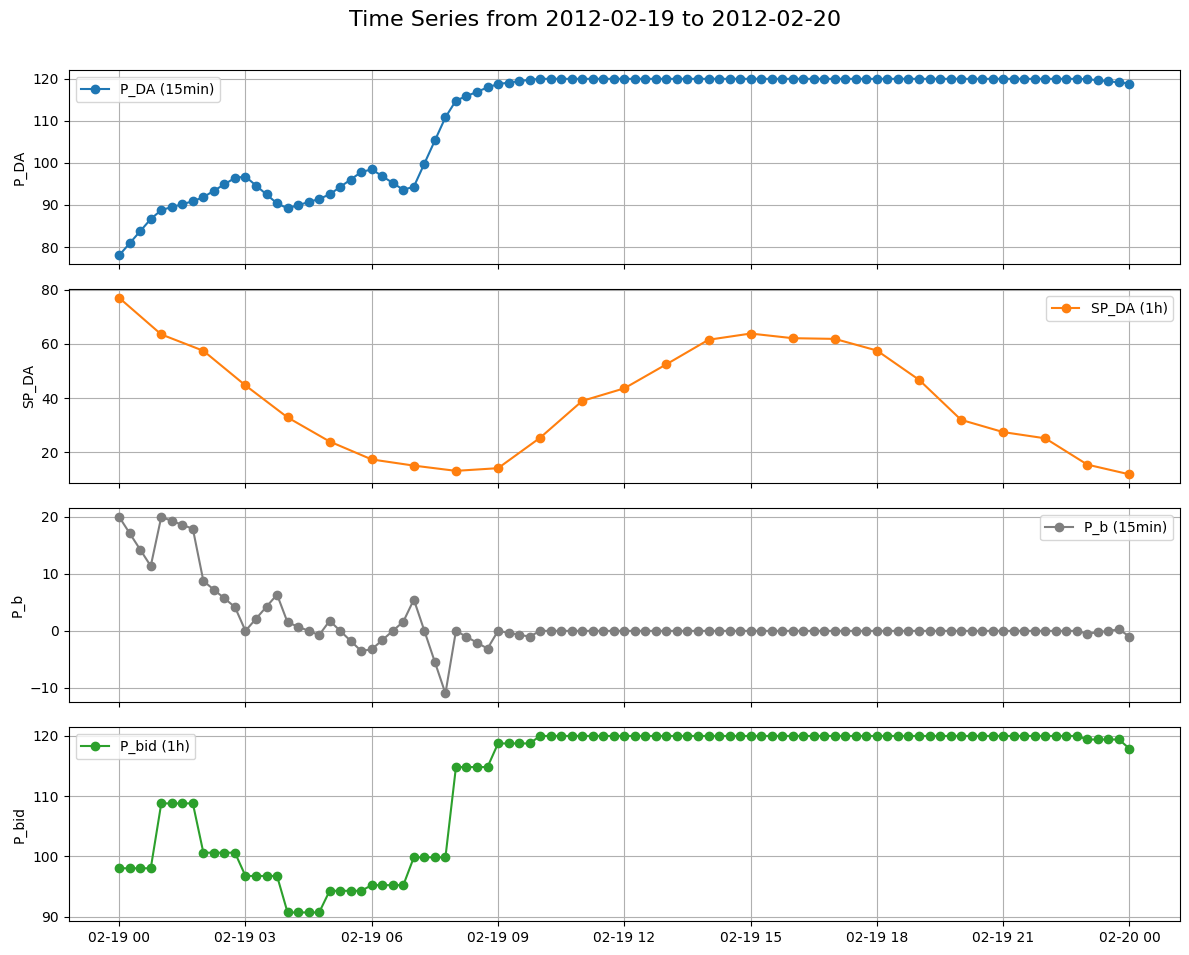

In [73]:
## wind forecast/DA price/DA schedule/SoC/curtailment (one day example to see how schedule respond to input data)

output_schedule_ts_filename = './DEMS/schedule.csv'
output_SoC_ts_filename = './DEMS/SoC.csv'
output_curtailment_ts_filename = './DEMS/curtailment.csv'

schedule = pd.read_csv(output_schedule_ts_filename)
SoC = pd.read_csv(output_SoC_ts_filename)
curtailment = pd.read_csv(output_curtailment_ts_filename)

schedule.index = date_range_15min[:-1]
SoC.index = date_range_15min[:-1]
curtailment.index = date_range_15min[:-1]



P_bid = schedule['SM']
SoC = SoC['SoC']
P_cur = abs(curtailment['RES_cur'])


start_date = '2012-02-19'
end_date = '2012-02-20'


date_range_15min_mask = (P_DA.index >= start_date) & (P_DA.index <= end_date)
date_range_1h_mask = (SP_DA.index >= start_date) & (SP_DA.index <= end_date)


P_DA_day = P_DA[date_range_15min_mask]
SP_DA_day = SP_DA[date_range_1h_mask]
P_bid_day = P_bid[date_range_15min_mask]
SoC_day = SoC[date_range_15min_mask]
P_cur_day = P_cur[date_range_15min_mask]
P_b_day = P_bid_day - P_DA_day

fig, axs = plt.subplots(4, 1, figsize=(12, 10), sharex=True)

axs[0].plot(P_DA_day, label='P_DA (15min)', color='tab:blue', marker='o')
axs[0].set_ylabel('P_DA')
axs[0].legend()
axs[0].grid(True)

axs[1].plot(SP_DA_day, label='SP_DA (1h)', color='tab:orange', marker='o')
axs[1].set_ylabel('SP_DA')
axs[1].legend()
axs[1].grid(True)

axs[2].plot(P_b_day, label='P_b (15min)', color='tab:gray', marker='o')
axs[2].set_ylabel('P_b')
axs[2].legend()
axs[2].grid(True)

axs[3].plot(P_bid_day, label='P_bid (1h)', color='tab:green', marker='o')
axs[3].set_ylabel('P_bid')
axs[3].legend()
axs[3].grid(True)



# axs[4].plot(P_cur_day, label='Curtailment (P_cur)', color='tab:red', marker='o')
# axs[4].set_ylabel('P_cur')
# axs[4].legend()
# axs[4].grid(True)

# axs[5].plot(SoC_day, label='SoC (15min)', color='tab:purple', marker='o')
# axs[5].set_ylabel('SoC')
# axs[5].set_xlabel('Time')
# axs[5].legend()
# axs[5].grid(True)

fig.suptitle(f'Time Series from {start_date} to {end_date}', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.97])
plt.show()

#### 2.2 Revenue analysis

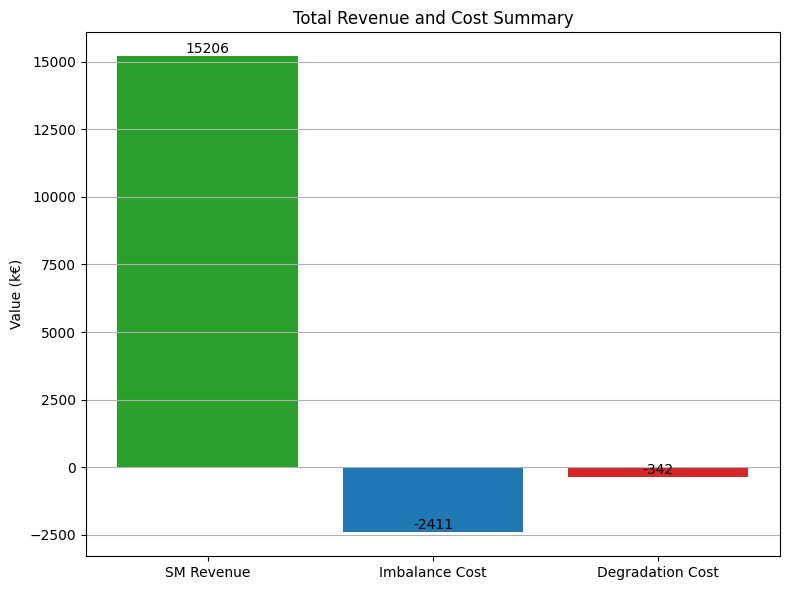

In [83]:
## revenue analysis (bar chart of spot price, imbalance revenue, degradation cost)

output_revenue_filename = './DEMS/revenue.csv'

revenue = pd.read_csv(output_revenue_filename)

SM_revenue = revenue['SM_revenue']
im_revenue = revenue['im_revenue']
Deg_cost = revenue['Deg_cost_by_cycle']


total_SM = SM_revenue.sum()/1000
total_im = im_revenue.sum()/1000
total_deg = Deg_cost.sum()/1000


labels = ['SM Revenue', 'Imbalance Cost', 'Degradation Cost']
values = [total_SM, total_im, -total_deg]


plt.figure(figsize=(8, 6))
bars = plt.bar(labels, values, color=['tab:green', 'tab:blue', 'tab:red'])


for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height,
             f'{height:.0f}', ha='center', va='bottom')

plt.title('Total Revenue and Cost Summary')
plt.ylabel('Value (k€)')
plt.grid(axis='y')
plt.tight_layout()
plt.show()


#### 2.3 Battery degradation analysis

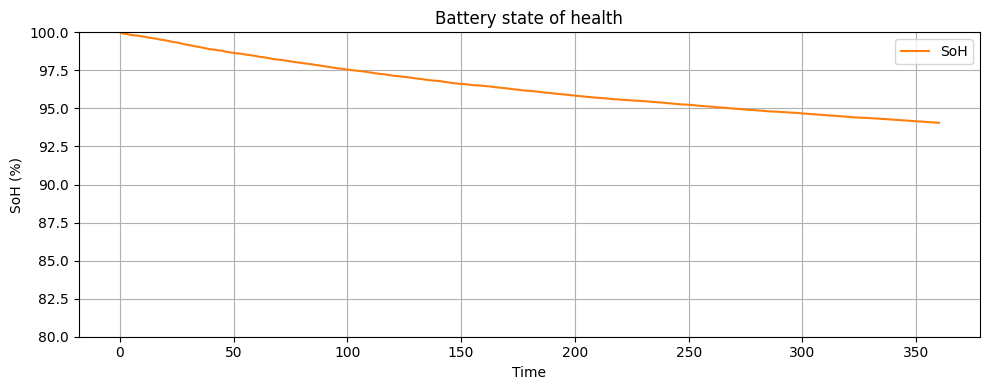

In [87]:
## Battery degradation analysis

output_degradation_filename = './DEMS/Degradation.csv'

degradation = pd.read_csv(output_degradation_filename)

nld = degradation['nld']*100


SoH = 100 - nld

# Plot
plt.figure(figsize=(10, 4))
plt.plot(SoH, label='SoH', color='tab:orange')
plt.title('Battery state of health')
plt.xlabel('Time')
plt.ylabel('SoH (%)')
plt.ylim([80,100])
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()